**Candidate Name:** Sneha Santha Prabakar

**Week 8:** Capstone Project Part 1

# Section 1: Import Library and Image

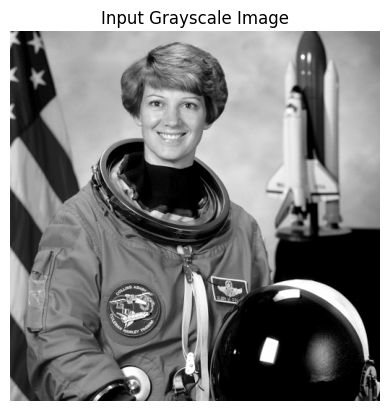

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data, img_as_float
from skimage.color import rgb2gray
import math

# Load a sample image from skimage (astronaut image is in color)
image = img_as_float(data.astronaut())  # Convert to float [0, 1]
gray_image = rgb2gray(image)  # Convert to grayscale

# Display input grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title("Input Grayscale Image")
plt.axis('off')
plt.show()

This grayscale image is derived from a color image using the rgb2gray() function, which applies a weighted sum over the RGB channels to retain perceived luminance.

- Grayscale conversion is essential in forward diffusion tasks to reduce dimensional complexity while preserving structural features.

- Pixel intensities are normalized between [0, 1] using img_as_float(), which facilitates consistent noise scaling and comparison.

- This step provides the clean baseline from which noise diffusion will be simulated in later stages.



## Section 2: Apply Timestamps

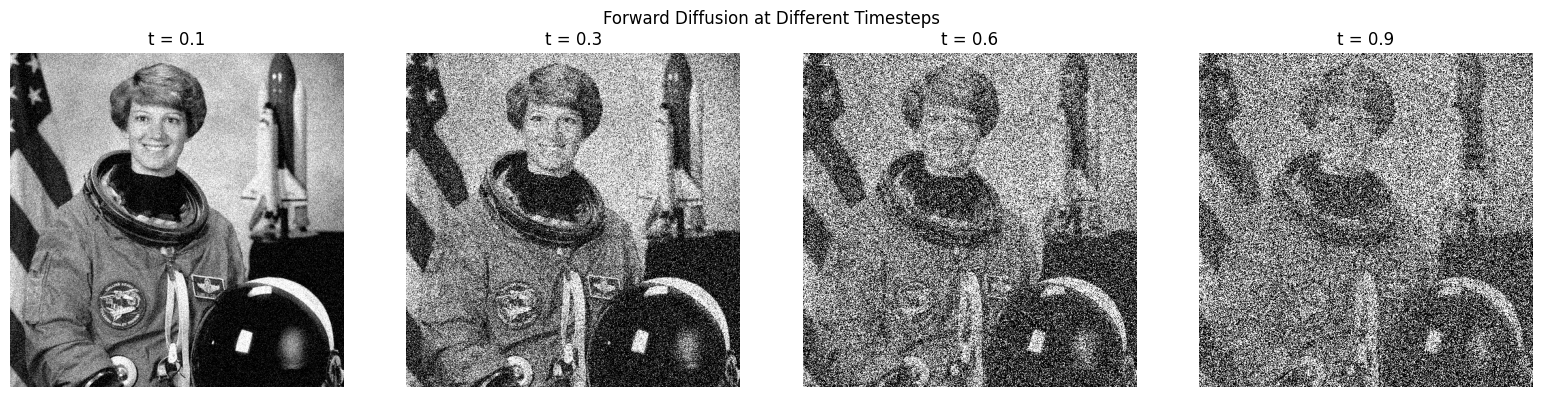

In [2]:
# Function to simulate forward diffusion: adds Gaussian noise based on timestep `t`
def add_noise(image, t):
    noise = np.random.normal(loc=0.0, scale=t, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)  # Keep values between 0 and 1
    return noisy_image

# Timesteps to visualize
timesteps = [0.1, 0.3, 0.6, 0.9]

# Plotting noisy images using subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, t in enumerate(timesteps):
    noisy = add_noise(gray_image, t)
    axs[i].imshow(noisy, cmap='gray')
    axs[i].set_title(f"t = {t}")
    axs[i].axis('off')

plt.suptitle("Forward Diffusion at Different Timesteps")
plt.tight_layout()
plt.show()


Each subplot shows the original grayscale image after Gaussian noise has been added at different noise levels (`t = 0.1, 0.3, 0.6, 0.9`).

Timestep `t` in diffusion represents the level of noise added — it linearly scales the standard deviation of the Gaussian distribution used to perturb the image.

As `t` increases, the noise overwhelms the image content:

At` t = 0.1`, the structure and identity of the subject are still clearly visible.

By `t = 0.9`, most fine details are obscured, showing how forward diffusion degrades information progressively.

This mimics how diffusion models degrade data in the forward process before learning to reverse it.

## Section 3: Apply noise schedule

In [3]:
def linear_schedule(t): return t
def cosine_schedule(t): return 0.5 * (1 - np.cos(np.pi * t))
def sigmoid_schedule(t): return 1 / (1 + np.exp(-10 * (t - 0.5)))


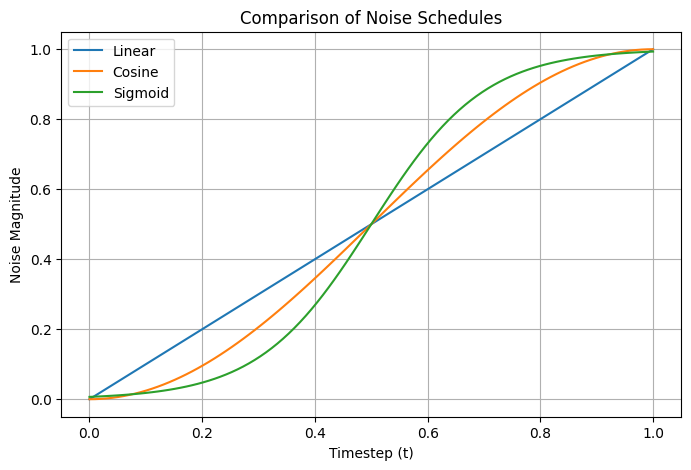

In [4]:
timesteps = np.linspace(0, 1, 100)

linear = [linear_schedule(t) for t in timesteps]
cosine = [cosine_schedule(t) for t in timesteps]
sigmoid = [sigmoid_schedule(t) for t in timesteps]

plt.figure(figsize=(8, 5))
plt.plot(timesteps, linear, label="Linear")
plt.plot(timesteps, cosine, label="Cosine")
plt.plot(timesteps, sigmoid, label="Sigmoid")
plt.title("Comparison of Noise Schedules")
plt.xlabel("Timestep (t)")
plt.ylabel("Noise Magnitude")
plt.legend()
plt.grid(True)
plt.show()


This plot shows how different noise schedules map timesteps (t) to noise magnitudes.

- Linear Schedule:

  - Adds noise at a constant rate across the diffusion process.

  - Easy to implement, but not always optimal for capturing complex image structures.

- Cosine Schedule:

  - Starts slow, then accelerates — better at preserving early image features.

  - Common in improved DDPMs due to its smooth growth and minimal early corruption.

- Sigmoid Schedule:

  - S-shaped curve with slow start and rapid middle transition.

  - Provides a balance between early detail preservation and late high noise.

Each schedule influences the learning dynamics of the model and how well it can reconstruct data from noisy samples.

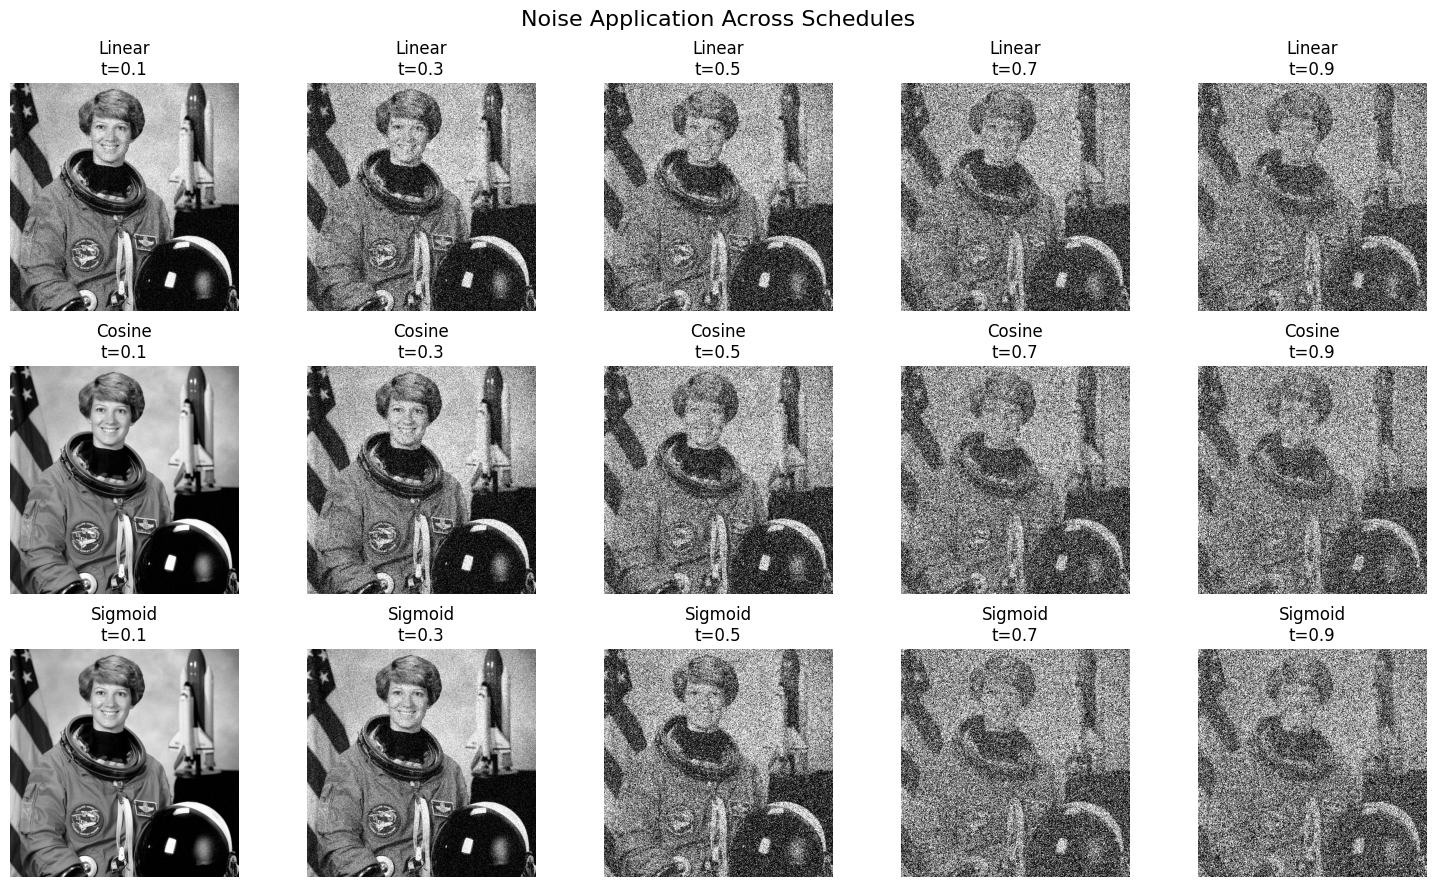

In [5]:
# Visualize how each schedule affects the image
schedule_functions = {
    'Linear': linear_schedule,
    'Cosine': cosine_schedule,
    'Sigmoid': sigmoid_schedule
}

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
step_values = [0.1, 0.3, 0.5, 0.7, 0.9]

for row_idx, (name, func) in enumerate(schedule_functions.items()):
    for col_idx, t in enumerate(step_values):
        scaled_t = func(t)
        noisy_img = add_noise(gray_image, scaled_t)
        axs[row_idx, col_idx].imshow(noisy_img, cmap='gray')
        axs[row_idx, col_idx].set_title(f"{name}\nt={t:.1f}")
        axs[row_idx, col_idx].axis('off')

plt.suptitle("Noise Application Across Schedules", fontsize=16)
plt.tight_layout()
plt.show()


This grid visualizes the impact of applying different schedules (Linear, Cosine, Sigmoid) across increasing timestep values (t = 0.1 to 0.9).

- Linear: Noise increases uniformly - details disappear steadily. Effective but can blur fine structure early.

- Cosine: Retains structural edges longer — early noise is gentler. Visually maintains more coherence in earlier timesteps.

- Sigmoid: Most dramatic noise jump appears between t=0.5 and t=0.7. Initially smooth, but becomes aggressive fast.

These differences affect how denoising networks are trained — they must learn to reverse noise patterns conditioned on both noise level and schedule type.

Choosing the right schedule is crucial for model performance, especially for fine-detail or high-resolution reconstructions.

# Compare diffusion models with GANs or VAEs, with a summary about noise and image structure (Approx. 100 words)

- Diffusion models offer a probabilistic framework where images are generated by reversing a gradual noising process.

- Unlike GANs, which learn a direct mapping from latent noise to data and often suffer from mode collapse,
diffusion models explore the data manifold step-by-step, maintaining diversity and fidelity.

- VAEs encode data into a latent space and decode back, but often produce blurrier outputs due to the Gaussian prior assumption.
In contrast, diffusion models capture fine-grained image structures through a learned denoising process.
Their step-wise noise handling enables better control over image realism and detail restoration,
making them highly effective for generative tasks, albeit with higher computational cost.
